## Anna Smirnova vs 19th-century Russian poetry

This notebook contains script used for the stylometric investigation of the hoax *Various Poems by Anna Smirnova* (Saint-Petersburg, 1837).

In [ ]:
library(tidyverse)
library(tidytext)

library(ape)
library(ggtree)

library(wesanderson)
library(patchwork)

### I. Corpus compilation

**Data are not fully available!**  
Most of the texts used in the experiment were taken from the Russian National Corpus; raw texts can be accessed by individuals only after contacting the Corpus directly. Thus the data placed in the repository are all poems by each author written in one file with words inside the file lemmatised and reshuffled. Female poets' texts (except for Anna Bunina's poems) digitized by me are available in the folder `data/corpus`.   


The present code shows the experiment settings and plot creation.  
The variable `fem_corpus` is a tibble with two columns: author names as `id`s and lemmatized texts merged together as `texts` (one row = one author's corpus)

In [14]:
#### load prepared data ####

# unzip the reshuffled and lemmatised corpus
unzip("data/corpus/corpus_chunks.zip", exdir = "data/corpus/corpus_chunks/")


# one file - texts from one author for one decade

files <- list.files(path = "data/corpus/corpus_chunks", pattern = ".txt$", full.names = T)
head(files)
length(files) # 37 chunks

[1] "data/corpus/corpus_chunks/Baratynskii_1820.txt"
[2] "data/corpus/corpus_chunks/Baratynskii_1840.txt"
[3] "data/corpus/corpus_chunks/Batyushkov_1800.txt" 
[4] "data/corpus/corpus_chunks/Batyushkov_1810.txt" 
[5] "data/corpus/corpus_chunks/Bunina_1800.txt"     
[6] "data/corpus/corpus_chunks/Bunina_1810.txt"

[1] 37

In [15]:
# read .txt files & compile the corpus

fem_corpus <- tibble(textpath = files,
                     texts = sapply(files, read_file))
fem_corpus <- fem_corpus %>%
  mutate(id = str_replace_all(textpath, ".*/(.*?).txt", "\\1")) %>% 
  mutate(texts = str_remove_all(texts, "[[:punct:]]"))

str(fem_corpus)

tibble [37 × 3] (S3: tbl_df/tbl/data.frame)
 $ textpath: chr [1:37] "data/corpus/corpus_chunks/Baratynskii_1820.txt" "data/corpus/corpus_chunks/Baratynskii_1840.txt" "data/corpus/corpus_chunks/Batyushkov_1800.txt" "data/corpus/corpus_chunks/Batyushkov_1810.txt" ...
 $ texts   : chr [1:37] "сходство дева зефир невольно знакомый случайный б но живитель ум разум утеха на крылатый в лицо князь носить ур"| __truncated__ "он ангел но по я злоба крыльцо я грудь поле прерывать ваш случайный удушать славный но один ничто горестный дол"| __truncated__ "увенчание мирный сходить как петербург отрада соловей перепелка дальный притекать сочинять сонм кляча вспыхиват"| __truncated__ "любовия вол как конец не змиист друг любовь образ дышать голос ли зарево то он вставать поздний восторг источни"| __truncated__ ...
 $ id      : chr [1:37] "Baratynskii_1820" "Baratynskii_1840" "Batyushkov_1800" "Batyushkov_1810" ...


Store basic corpus stats, showed in `data/addition`

In [16]:
# Count number of tokens by each author 

author_counter <- fem_corpus %>% 
  unnest_tokens(input = texts, output = word, token = "words") %>% 
  count(id, sort = T)

head(author_counter)

# write.csv(file = "data/additional/corpus_sizes.csv", author_counter)

id,n
<chr>,<int>
Pushkin_1820,96918
Zhukovskii_1810,84566
Zhukovskii_1830,52508
Pushkin_1830,51242
Bunina_1800,46028
Bunina_1810,46028


In [17]:
# word frequencies 

word_counter <- fem_corpus %>% 
  unnest_tokens(input = texts, output = word, token = "words") %>% 
  count(word, sort = T)

head(word_counter)

# save ranks from 1 to 400
# write.csv(file = "data/additional/ranks_1_400MFW.csv", word_counter[1:400,])

word,n
<chr>,<int>
и,37252
в,26429
я,17974
не,15225
он,13180
с,12836


### Experiment

The loop below take the data from the `fem_corpus`, tokenize it and sample randomly 8k words from each author's corpus.  
After sampling, all the resulting matrices with scaled word frequencies were stored in the variable "matrices" (list) and available as `data/Smirnova_matrices.Rda`.  
The resulting list of phylo lists is stored as the `data/Smirnova_list_of_trees.Rda`.

In [18]:
####### Experiment settings #######

n_iterations <- 100
list_of_trees <- vector(length=n_iterations, mode="list")
matrices <- list()

for(i in 1:n_iterations) {
  
  message(paste0("Iteration -- ", i))
  
  # random sampling; 8000 words were chosen from each author's corpus
  sampled <- fem_corpus %>% # fem_corpus is the variable containing the data: id = author's name, texts = all texts by the author merged together as a character vector
    unnest_tokens(input = texts, output = word, token = "words") %>% 
    group_by(id) %>% 
    sample_n(8000) %>% 
    ungroup()
  
  # counting word frequencies
  counted <- sampled %>% 
    count(word, sort = T)
  
  # long table to matrix
  wide <- sampled  %>% 
    group_by(id)  %>% 
    count(word) %>%
    mutate(n=n/sum(n)) %>% 
    spread(key=word, value=n, fill = 0)
  
  names <- wide$id
  matrix <- wide[,-1]
  
  # normalization
  mat_fin <- matrix[counted$word] %>% as.matrix() %>% scale()
  rownames(mat_fin) <- names
  
  # counting distances for 250 MFW starting from the 50th
  mat_fin <- mat_fin[,50:299]
  
  # store matrix
  matrices[[i]] <- mat_fin
  
  # calculating distances
  distances <- stylo::dist.delta(mat_fin)
  
  # clusterisation 
  list_of_trees[[i]] <- distances %>% 
    hclust(method = "ward.D2") %>% 
    as.phylo()
  
}

Iteration -- 1

Iteration -- 2

Iteration -- 3

Iteration -- 4

Iteration -- 5

Iteration -- 6

Iteration -- 7

Iteration -- 8

Iteration -- 9

Iteration -- 10

Iteration -- 11

Iteration -- 12

Iteration -- 13

Iteration -- 14

Iteration -- 15

Iteration -- 16

Iteration -- 17

Iteration -- 18

Iteration -- 19

Iteration -- 20

Iteration -- 21

Iteration -- 22

Iteration -- 23

Iteration -- 24

Iteration -- 25

Iteration -- 26

Iteration -- 27

Iteration -- 28

Iteration -- 29

Iteration -- 30

Iteration -- 31

Iteration -- 32

Iteration -- 33

Iteration -- 34

Iteration -- 35

Iteration -- 36

Iteration -- 37

Iteration -- 38

Iteration -- 39

Iteration -- 40

Iteration -- 41

Iteration -- 42

Iteration -- 43

Iteration -- 44

Iteration -- 45

Iteration -- 46

Iteration -- 47

Iteration -- 48

Iteration -- 49

Iteration -- 50

Iteration -- 51

Iteration -- 52

Iteration -- 53

Iteration -- 54

Iteration -- 55

Iteration -- 56

Iteration -- 57

Iteration -- 58

Iteration -- 59

Iterat

## Plot

In [11]:
# Load data for the tree visualisation

load("data/Smirnova_list_of_trees__delta.Rda")

In [19]:
# creating the consensus tree with 50% agreement
consensus = ape::consensus(list_of_trees, p=0.5)

# making the main plot
figure <- ggtree(consensus,
            size=0.5) 

In [20]:
# create variable for adding additional colouring to tip.labels

# take tip.labels
tree_groups <- data.frame(
  "id" = c(consensus$tip.label))

# attach a grouping column
tree_groups <- tree_groups %>% 
  mutate(colour = ifelse(str_detect(id, "Bunina|Kulmann|Rostopchina|Pospelova|Shakhova"), 
                         "f", 
                         "m")) %>% 
  mutate(colour = ifelse(id == "Smirnova_1830", 
                         "target", 
                         colour))

head(tree_groups)

,id,colour
,<chr>,<chr>
1,Baratynskii_1820,m
2,Baratynskii_1840,m
3,Batyushkov_1800,m
4,Batyushkov_1810,m
5,Bunina_1800,f
6,Bunina_1810,f


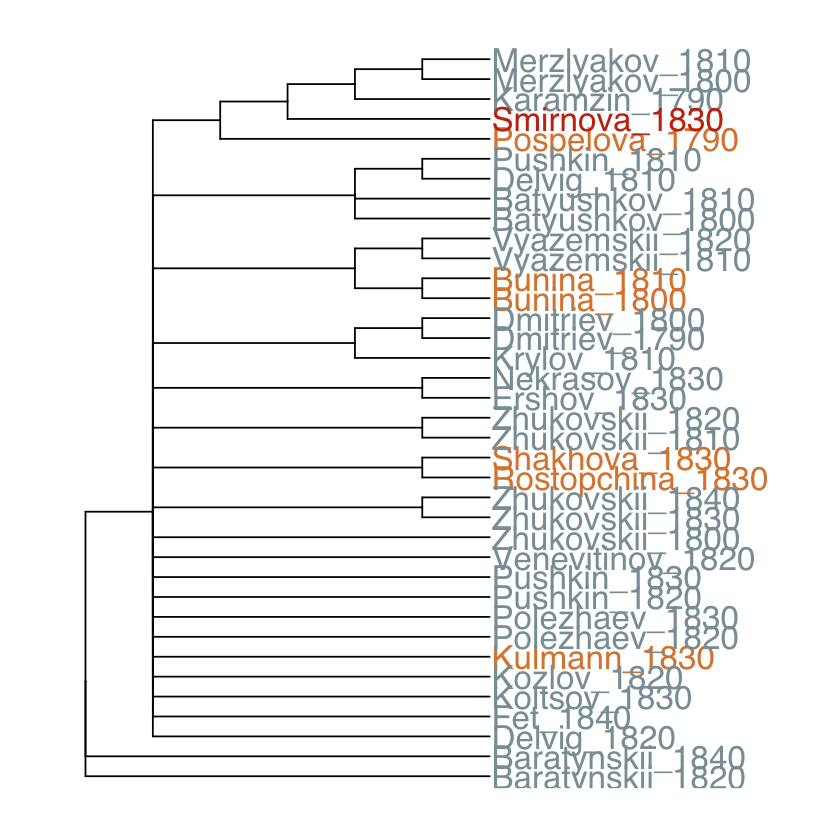

In [21]:
# create main tree

f2 <- figure %<+% tree_groups + 
  scale_color_manual(values = c(
    wes_palette("Royal1")[4], # female
    wes_palette("Royal1")[1], # male 
    wes_palette("Royal1")[2] # smirnova
    )) +
  geom_tiplab(aes(color = colour), size=7) + 
  #guides(color=F) + 
  theme(plot.margin = unit(rep(1,4), "cm"),
       legend.position = "None") + 
  xlim(0, 10) 

print(f2)

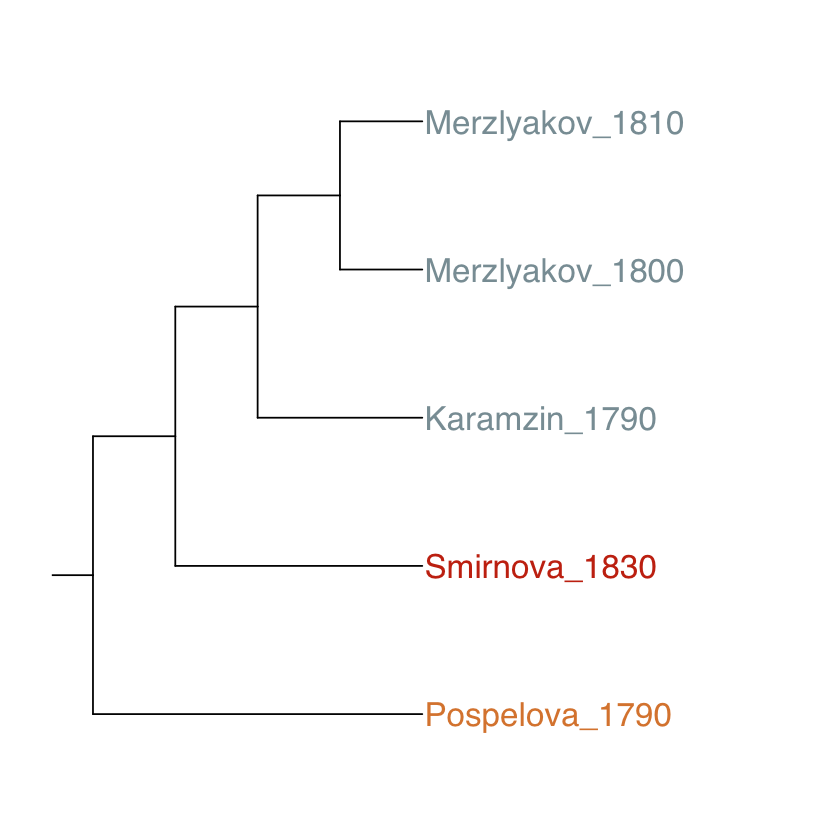

In [22]:
# select a clade

clade <- f2

f_zoom <- viewClade(clade, MRCA(clade, 
                               "Smirnova_1830", "Pospelova_1790"
                               ))

print(f_zoom)

In [ ]:
# plot merging and saving

layout <- "
AAA##
AAABB
AAA##
"

f2 + f_zoom + plot_layout(design = layout)

# ggsave("plots/Smirnova_Figure_patch_delta.png", plot = last_plot(), width = 15, height = 11, dpi = 300, bg = "white")